## Fan Charts - IDB

#### Importing Libraries

In [51]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt

#### Defining parameters for the example

In [28]:
alpha_TEST=0.5      ##Proporción de deuda en moneda local 
rt_ml_TEST=0.01     ##es la tasa de interés nominal de la deuda en moneda local
rt_me_TEST=0.02     ##es la tasa de interés nominal de la deuda en moneda extranjera
deltae_TEST=0.01    ##Depreciación de la moneda
Ft_TEST=0.1         ##Balance primario
gild_TEST=1         ##Tasa de crecimiento de ingresos de libre destino
gide_TEST=0.01      ##Tasa de crecimiento de ingresos de destinación específica
ggp_TEST=0.01       ##Tasa de crecimiento del gasto primario
GPPrev_TEST=0.01    ##Gasto primario
D0_test=1           ##Nivel inicial de la deuda
T_test=5            ##Number of periods that will be predicted
InitialConditionsTest=np.random.rand(6,1)*0.1   ##This vector stores the level of the following variables in the period
                                                ##zero: (rt_ml,rt_me,et,gild,tide,ggp)

#Psi distribution: Need to assume distribution of six variables. Variance-covariance matrix (OMEGA), mu_0, and mu_1. 
#First, create random matrix:
np.random.seed(2581633)
A=np.random.rand(6,6)

#Matrix Omega of test. This is the variance covariance matrix of the following variables:
#(rt_ml,rt_me,et,gild,tide,ggp)

OMT=np.matmul(A, A.T)

#Vector mu_0 and matrix mu_1. These parameters describe the evolution of mu_0, mu_1. 

mu_0 = 0.01*np.arange(6).reshape(6, 1)+0.1
mu_1 = np.random.rand(6,6)*0.01

#Drawing the random shocks. 10,000 and assuming T=5. 
#T will be defined in T_test. 
means=np.zeros(6)   ##These are the means of the shocks which will always be zero. 

Y = np.random.multivariate_normal(means, OMT, 10000*T_test).T
#Y2 will store a 6X10,000xT matrix with the shocks. Reshape with 3d array. 
Y2=Y.reshape((6,10000,T_test))



In [29]:
print(Y.shape)
print(Y2.shape)
print(mu_1.shape)
print(type(OMT))
print(type(mu_0))
print(type(mu_1))
print(type(T_test))
print(InitialConditionsTest.shape)
print(type(InitialConditionsTest))


(6, 50000)
(6, 10000, 5)
(6, 6)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'int'>
(6, 1)
<class 'numpy.ndarray'>


In [30]:
def FanChartVAR(Omega,mu_0,mu_1,T,InitialConditions):
    
    #Means of shocks is around zero
    means=np.zeros(6)
    
    #Need to set seed to obtain same shocks every time
    np.random.seed(2581633)
    
    #Generate vector of (6)X10,000*T
    Y = np.random.multivariate_normal(means, Omega, 10000*T).T
    
    #Turn into 3d array
    Y2=Y.reshape((6,10000,T_test))
    
    #Generate the vector of predictions
    Predictions=np.zeros((6,10000,T))
    
    #Generate the initial predictions
    Predictions[:,:,0]=mu_0+np.matmul(mu_1,InitialConditions)+Y2[:,:,0].reshape((6,10000))
    
    #Looping over time to obtain the remaining predictions
    for t in range(1, T_test):
        Predictions[:,:,t]=mu_0+np.matmul(mu_1,Predictions[:,:,t-1])+Y2[:,:,t].reshape((6,10000))
    
    return(Predictions)

In [31]:
YTOTAL=FanChartVAR(OMT,mu_0,mu_1,T_test,InitialConditionsTest)

#Load the corresponding output of YTotal into the necessary variables. 

rml=YTOTAL[0,:,:]
rme=YTOTAL[1,:,:]
et=YTOTAL[2,:,:]
gild=YTOTAL[3,:,:]
gnild=YTOTAL[4,:,:]
ggp=YTOTAL[5,:,:]


In [32]:
#Obtaining the depreciation rate
def Depreciation(et,e0_level,T):
    
    #The e0 is given by the initial condition. 
    #et is the prediction of the exchange rates generated in the function FanChartVAR
    DepReturn=np.zeros((10000,T))
    
    #Depreciation between period 0 and 1:
    DepReturn[:,0]=(et[:,0]-e0_level)/e0_level
    for t in range(1, T):
        DepReturn[:,t]=(et[:,t]-et[:,t-1])/et[:,t-1]
    return(DepReturn)

In [33]:
Dep=Depreciation(et,InitialConditionsTest[2,0],T_test)

In [34]:
ILD0_test=1.3
print(type(ILD0_test))
IDE0_test=1
GP0_test=1
#Function predicting ILD:
def ILDT(gild,T,ILD0):

    #Obtaining ILD: Assuming initial condition for ILD0
    
    ILD=np.zeros((10000,T))

    #Broadcasting initial condition
    ILD[:,0]=ILD0
    
    #Predicting
    for t in range(1,T_test):
        ILD[:,t]=(1+gild[:,t-1])*ILD[:,t-1]

    return(ILD)


<class 'float'>


In [35]:
#Testing ILDT and IDE
ILD=ILDT(gild,T_test,ILD0_test)
IDE=ILDT(gnild,T_test,IDE0_test)
GP=ILDT(ggp,T_test,GP0_test)
print(ILD.shape)


(10000, 5)


In [36]:
#Function predicting FT:
def FTPRED(ILD,IDE,GP):
    return(ILD+IDE-GP)

In [37]:
FT_Test=FTPRED(ILD,IDE,GP)
print(FT_Test.shape)

(10000, 5)


In [38]:

print(Dep.shape)
#Predicting DT
DT=np.zeros((10000,5))
DT[:,0]=D0_test
for t in range(1,T_test):
    DT[:,t]=(alpha_TEST*(1+rml[:,t])+(1-alpha_TEST)*(1+rme[:,t])*(1+Dep[:,t-1]))*DT[:,t-1]-FT_Test[:,t]
#def DTPREDICTION(alpha,rml,rme,deval,D0,FT):
    

(10000, 5)


In [39]:
print(DT.shape)

(10000, 5)


## Finalmente. Deuda como proporción de ILD

In [40]:
FC=DT/ILD

In [55]:
l1=np.zeros(10000)+1
l2=np.append(l1,np.zeros(10000)+2)
l3=np.append(l2,np.zeros(10000)+3)
l4=np.append(l3,np.zeros(10000)+4)
l5=np.append(l4,np.zeros(10000)+5)
print(FC.shape)
print(l5.shape)



(10000, 5)
(50000,)


In [42]:
y1=FC[:,0]
y2=np.append(y1,FC[:,1])
y3=np.append(y2,FC[:,2])
y4=np.append(y3,FC[:,3])
y5=np.append(y4,FC[:,4])

In [74]:
l1=np.zeros(10000)+1
for d in range(2,6):
    print(d)
    l1=np.append(l1,np.zeros(10000)+d)
    
print(l1.shape)
print(l5.shape)

2
3
4
5
(50000,)
(50000,)


### Fan Chart

In [73]:
y1TEST=FC[:,0]
for d in range(1,5):
    print(d)
    y1TEST=np.append(y1TEST,FC[:,d])
print(y1TEST)


1
2
3
4
[ 0.76923077  0.76923077  0.76923077 ...  0.07308573 -0.77141232
 -0.91226939]


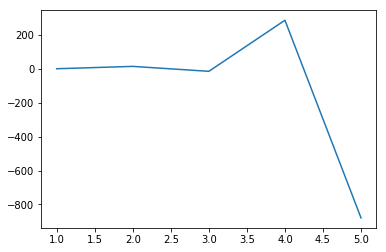

In [75]:
coefs = poly.polyfit(l1, y1TEST, 4)
ffit = poly.polyval(l1, coefs)
plt.plot(l1, ffit)

<class 'numpy.ndarray'>


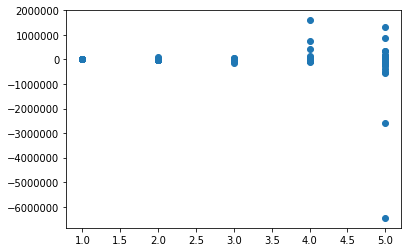

In [78]:
print(type(ffit))
plt.scatter(l1,y1TEST)

In [79]:
print(y1TEST.shape)

(50000,)


In [85]:
proba=sum(FC[:,4]>2)/10000

In [86]:
print(type(proba))

<class 'numpy.float64'>
